In [1]:
import numpy as np
import pandas as pd
import torch
import nltk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

c:\Users\drebi\miniconda3\envs\FinBERT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090


In [47]:
# Check if CUDA is available and set the default tensor type to use CUDA if available


In [48]:
news_df = pd.read_csv('data/news.csv')
stock_df = pd.read_csv('data/price.csv')


In [49]:
stock_df.head()

,Date,ticker,close
0,2017-01-03,A,43.743862
1,2017-01-04,A,44.317825
2,2017-01-05,A,43.790924
3,2017-01-06,A,45.155281
4,2017-01-09,A,45.296406


In [50]:
nltk.download("vader_lexicon")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, max_length=512, truncation=True)

def predict_sentiment(text):
    inputs = finbert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = finbert(**inputs)
    scores = outputs.logits.softmax(dim=1).numpy()[0]
    return scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\drebi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Using device: cuda


In [51]:
# Convert the list of scores into a DataFrame with separate columns
sentiment_df = pd.DataFrame(news_df['body'].apply(predict_sentiment).tolist(), columns=['neutral', 'positive', 'negative'])

# Append the new columns to news_df
news_df = pd.concat([news_df.reset_index(drop=True), sentiment_df], axis=1)

In [24]:
def VADER_sentiment_score(heading):
    """
    Returns all VADER sentiment scores
    - neg: Negative sentiment (0 to 1)
    - neu: Neutral sentiment (0 to 1)
    - pos: Positive sentiment (0 to 1)
    compound: Normalized aggregate score (-1 to 1)
    """

    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(heading)

In [53]:
VADER_negative = []
VADER_neutral = []
VADER_positive = []
VADER_compound = []


for i in range(len(news_df)):
    
    headline = news_df.iloc[i]['title']

    # Analyze headline with VADER
    vader_scores = VADER_sentiment_score(headline)
    VADER_negative.append(vader_scores['neg'])
    VADER_neutral.append(vader_scores['neu'])
    VADER_positive.append(vader_scores['pos'])
    VADER_compound.append(vader_scores['compound'])


    # Optional: Print progress every 100 items
    if i % 100 == 0:
        print(f"Processed {i} items")


    # Get all sentiment scores

# Add all scores to the dataframe
news_df['VADER_negative'] = VADER_negative
news_df['VADER_neutral'] = VADER_neutral
news_df['VADER_positive'] = VADER_positive
news_df['VADER_compound'] = VADER_compound


Processed 0 items
Processed 100 items
Processed 200 items
Processed 300 items
Processed 400 items
Processed 500 items
Processed 600 items
Processed 700 items
Processed 800 items
Processed 900 items
Processed 1000 items
Processed 1100 items
Processed 1200 items
Processed 1300 items
Processed 1400 items
Processed 1500 items
Processed 1600 items
Processed 1700 items
Processed 1800 items
Processed 1900 items
Processed 2000 items
Processed 2100 items
Processed 2200 items
Processed 2300 items
Processed 2400 items
Processed 2500 items
Processed 2600 items
Processed 2700 items
Processed 2800 items
Processed 2900 items
Processed 3000 items
Processed 3100 items
Processed 3200 items
Processed 3300 items
Processed 3400 items
Processed 3500 items
Processed 3600 items
Processed 3700 items
Processed 3800 items
Processed 3900 items
Processed 4000 items
Processed 4100 items
Processed 4200 items
Processed 4300 items
Processed 4400 items
Processed 4500 items
Processed 4600 items
Processed 4700 items
Proc

In [54]:
news_df.head()

,publication_datetime,title,body,tickers,neutral,positive,negative,VADER_negative,VADER_neutral,VADER_positive,VADER_compound
0,2017-01-03,World News: Police Question Netanyahu Over Gifts,"""We pay attention to publications in the media...",EL,0.999937,0.000002,0.000060,0.0,1.000,0.000,0.0000
1,2017-01-03,Business News: Nestle Turns to New CEO for Hea...,"Nestle, the world's largest packaged-food comp...",GIS,0.444897,0.551795,0.003308,0.0,1.000,0.000,0.0000
2,2017-01-03,Business News: Vermont Drug Law Faces Limits -...,"The Vermont law, enacted in June, instructed s...",ABBV,0.999891,0.000026,0.000083,0.0,1.000,0.000,0.0000
3,2017-01-03,Life & Arts -- Travel: How Hotel Companies Lau...,Travelers are about to see a flurry of new hot...,HLT,0.999991,0.000006,0.000003,0.0,1.000,0.000,0.0000
4,2017-01-03,Businesses Ready to Ramp Up Investment --- Aft...,The Federal Reserve last month signaled intere...,HD,0.984549,0.013953,0.001498,0.0,0.894,0.106,0.3612


In [56]:
news_df.to_csv('data/news_w_sentiment.csv', index=False)


In [22]:
news_df = pd.read_csv('data/news_w_sentiment.csv')


In [23]:
# hyperparameters
split = (0.75);
sequence_length = 10;
epochs = 100
learning_rate = 0.02


In [24]:
# loading stock price data
stock_data = pd.read_csv("stock_price.csv")
column = ['Close']

In [25]:
len_stock_data = stock_data.shape[0]


# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

In [26]:
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [27]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

In [28]:
# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


In [35]:
# creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units=50, activation="tanh", return_sequences=True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units=20, activation="tanh", return_sequences=False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units=1, activation="linear"),
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    )

    # Fit the model and store the history
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_split=0.2,
        verbose=1
    )
    return model, history


# inverting normaliztion
y_test = scaler.inverse_transform(y_test)


# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, 1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)


def run_model(n):

    total_mae = total_mape = total_acc = 0
    histories = []

    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape
        total_acc += acc
        histories.append(history)

    return (total_mae / n), (total_mape / n), (total_acc / n), histories, predictions.tolist()

In [36]:
mae, mape, acc, histories, preds = run_model(1)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2354 - val_loss: 0.0298
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0628 - val_loss: 0.0621
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0343 - val_loss: 0.0155
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0135 - val_loss: 0.0118
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0059 - val_loss: 0.0130
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - val_loss: 0.0116
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0111
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0106
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0112
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0102
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0113
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

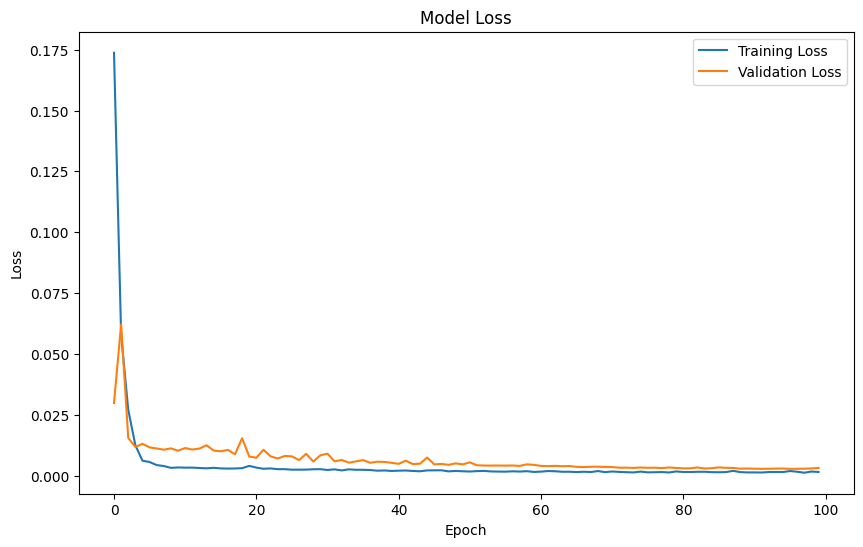

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(histories[0].history['loss'], label='Training Loss')
plt.plot(histories[0].history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()